# Imagenet Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `imagenet_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance

* Dataset size: `146.899991342 GB` (`imagenet/ILSVRC/Data/CLS-LOC/train> du -hb .` / 1000 / 1000)
* Amount of `.JPEG` files: `1281167` (`imagenet/ILSVRC/Data/CLS-LOC/train> find . -name "*.JPEG" | wc -l`)
* Avg. filesize: `0.11466107957978935 MB`
* Avg. resolution (Imagenet paper): `400x350`
* Sample sizes (rounded to second decimal):
    * `   0500:        57.33 MB` 
    * `   1000:       114.66 MB`
    * `   2000:       229.32 MB`
    * `   4000:       458.64 MB`
    * `   8000:       917.29 MB`
    * `1281167: 146899.99 MB` 

In [1]:
full_dataset_samplecount = 1281167
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_samplecount * 100, 2)}%")

500 of total: 0.04%
1000 of total: 0.08%
2000 of total: 0.16%
4000 of total: 0.31%
8000 of total: 0.62%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')

from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [3]:
local_fig_dir = "imagenet-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)

home_path = "../logs/final-logs/imagenet/main-experiments"
path_to_cum_df = f"{home_path}/imagenet-cached-storage-ceph-hdd_2021-10-03-00:28:40_cum-df_samples-500-1000-2000-4000-8000-1281167_threads-1-2-4-8.csv"
path_to_cum_dstat_df = f"{home_path}/imagenet-cached-storage-ceph-hdd_2021-10-03-00:28:40_cum-dstat-df_samples-500-1000-2000-4000-8000-1281167_threads-1-2-4-8.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["unprocessed", "concatenated", "decoded", "resized", "pixel-\ncentered"]

In [4]:
cum_df.head(5)

,offline_processing_and_save_time_s,shard_count,thread_count,shard_cum_size_MB,sample_count,online_processing_time_s,throughput_sps,runs_count,runs_total,ueid,split_name,creation_timestamp,compression_type,storage_type
0,0.0,1,1,0.0,500,23.132196,21.614895,0,3,8c6e03,0-fully-online,2021-10-03-00:28:40,none,ceph-hdd
1292,0.0,2,2,0.0,1000,21.549641,46.404488,2,3,2badc9,0-fully-online,2021-10-03-16:45:22,none,ceph-hdd
572,0.0,8,8,0.0,4000,33.248375,120.306625,2,3,5b32cd,0-fully-online,2021-10-03-07:36:14,none,ceph-hdd
992,0.0,2,2,0.0,1000,22.216690,45.011204,2,3,4bd2f8,0-fully-online,2021-10-03-13:08:30,none,ceph-hdd
991,0.0,2,2,0.0,1000,22.222311,44.999817,1,3,4bd2f8,0-fully-online,2021-10-03-13:08:30,none,ceph-hdd


In [5]:
cum_dstat_df.head(5)

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,...,vm_allocated_mb,vm_free_mb,filesystem_files,filesystem_inodes,filelocks_posix,filelocks_lock,filelocks_read,filelocks_write,compression_type,storage_type
0,0.0,0.061643,0.017828,0.000000,0.000000,1,500,1,1,8c6e03,...,0.00,0.0,1440.0,18377.0,3.0,2.0,0.0,5.0,none,ceph-hdd
1,1.0,0.000000,0.000000,0.000881,0.000207,1,500,1,1,8c6e03,...,0.00,0.0,1440.0,18377.0,3.0,2.0,0.0,5.0,none,ceph-hdd
2,2.0,0.000000,0.000000,0.000180,0.000000,1,500,1,1,8c6e03,...,0.00,0.0,1440.0,18377.0,3.0,2.0,0.0,5.0,none,ceph-hdd
3,3.0,0.000000,0.000000,4.340296,0.035201,1,500,1,1,8c6e03,...,0.01,0.0,1440.0,18408.0,3.0,2.0,0.0,5.0,none,ceph-hdd
4,4.0,0.000000,0.000000,2.568192,0.035851,1,500,1,1,8c6e03,...,0.01,0.0,1440.0,18444.0,3.0,2.0,0.0,5.0,none,ceph-hdd


## 0. Experiment Information

### 0.1 Experiment Count
We define an experiment as profiling a materialization strategy (e.g., `0-fully-online`) with a certain sample count (e.g., `500`).

We replicated **every** experiment **5** times, that means we should have `5 * <mat-strategies> * <thread_count>` experiments for each sample size. The only exception is the full dataset preprocessing, which is ran with `thread_count = 8`

Unfortunately the `ueid`s are based on the way the experiments were ran (in the python loop vs. bash loop), so we only count the rows, as each row in the `cum_df` dataframe is a single experiment.

In [6]:
experiment_count_dict = {
    "sample_count": []
  , "sample_experiment_count": []
  , "thread_count": []
  , "thread_experiment_count": []
  , "norm_thread_experiment_count": []
  , "runs_count": []
  , "runs_experiment_count": []
}

def get_experiment_count(df):
    '''Short helper'''
    return len(df.index)

def add_to_dict(sample_count, sample_experiment_count
              , thread_count, thread_experiment_count, norm_thread_experiment_count
              , runs_count, runs_experiment_count):
    '''Short helper'''
    experiment_count_dict["sample_count"] += [sample_count]
    experiment_count_dict["sample_experiment_count"] += [sample_experiment_count]
    experiment_count_dict["thread_count"] += [thread_count]
    experiment_count_dict["thread_experiment_count"] += [thread_experiment_count]
    experiment_count_dict["norm_thread_experiment_count"] += [norm_thread_experiment_count]
    experiment_count_dict["runs_count"] += [runs_count]
    experiment_count_dict["runs_experiment_count"] += [runs_experiment_count]


for sample_count in cum_df["sample_count"].unique():
    sample_experiment_count = get_experiment_count(cum_df.query(f"sample_count=={sample_count}"))
    # for each thread setting
    for thread_count in cum_df.query(f"sample_count=={sample_count}")['thread_count'].unique():
        thread_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count}'))
        norm_thread_experiment_count = thread_experiment_count / len(strategies)        
        # for each run (epoch)
        for runs_count in cum_df.query(f"sample_count=={sample_count} and thread_count=={thread_count}")['runs_count'].unique():
            runs_experiment_count = get_experiment_count(cum_df.query(f'sample_count=={sample_count} and thread_count=={thread_count} and runs_count=={runs_count}'))
            add_to_dict(sample_count, sample_experiment_count,
                        thread_count, thread_experiment_count, norm_thread_experiment_count, runs_count, runs_experiment_count)
        
experiment_count_df = pd.DataFrame.from_dict(experiment_count_dict)
experiment_count_df

,sample_count,sample_experiment_count,thread_count,thread_experiment_count,norm_thread_experiment_count,runs_count,runs_experiment_count
0,500,300,1,75,15.0,0,25
1,500,300,1,75,15.0,2,25
2,500,300,1,75,15.0,1,25
3,500,300,2,75,15.0,0,25
4,500,300,2,75,15.0,1,25
5,500,300,2,75,15.0,2,25
6,500,300,8,75,15.0,2,25
7,500,300,8,75,15.0,1,25
8,500,300,8,75,15.0,0,25
9,500,300,4,75,15.0,1,25


# 1. Storage Consumption vs Throughput Tradeoffs
### Full dataset, 8 threads, epoch 0

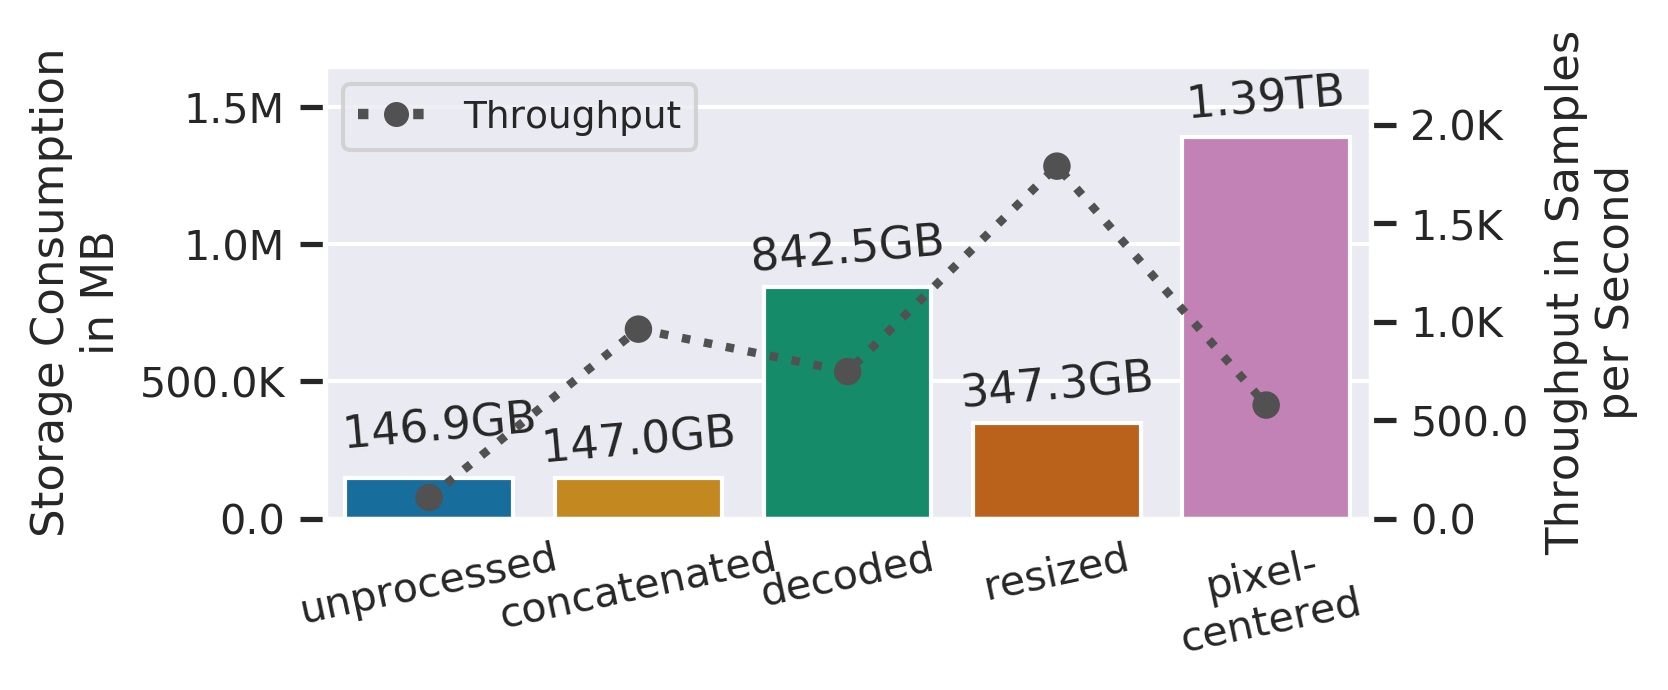

In [7]:
cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 \
                         and runs_count==0")

sample_size_mb_dict = {
    "500": 58.42
  , "1000": 116.84
  , "2000": 233.68
  , "4000": 467.35
  , "8000": 934.71
  , f"{full_dataset_samplecount}": 146899.991342
}

storage_consumption_comparison = {
    "storage_consumption_mb": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption_mb"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df_temp.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df_temp.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

sns.set(palette=default_palette, font_scale=0.9)
throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps", data=cum_df_temp,
                      ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples\nper Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=5, color=throughput_color, lw=2.5, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 2300))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption_mb",
        data=storage_df.query(f"sample_count=={full_dataset_samplecount}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=12
)
plot.tick_params(axis='x', which='major', pad=-1.5)
show_values_on_bars(plot, h_v="v", space=120000, rotation=5, additional_x_space=[0.05,0,0,0,0]
                                                            , additional_space=[50000,0,0,0,0], storage_formatting=True)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.set(ylim=(0, 1650000))

plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("storage-vs-throughput")

# 2. Caching Analysis
### Full dataset, 8 threads, epoch 0 + 1 + 2

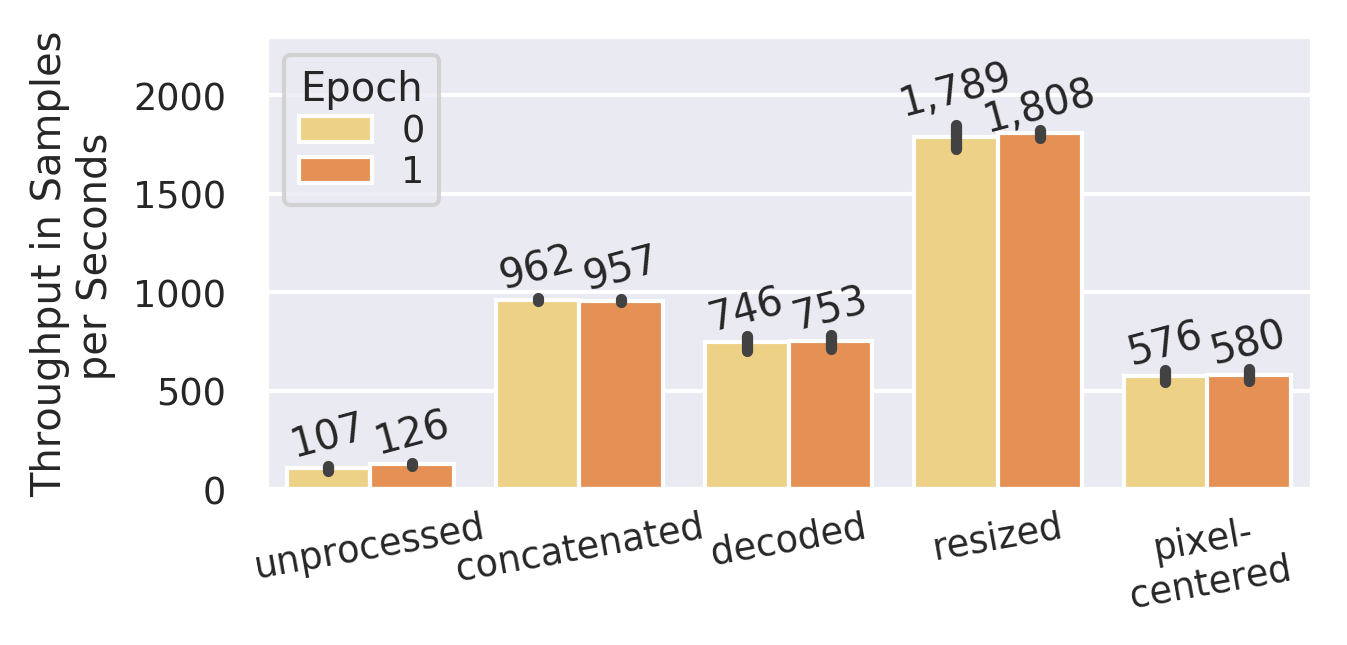

In [8]:
sns.set(palette=epoch_palette, font_scale=0.8)

cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 and runs_count<=1")

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(xlabel="", ylabel="Throughput in Samples\n per Seconds")
plot.set(ylim=(0, 2300))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1, loc="upper left")
show_values_on_bars(plot, h_v="v", space=150, rotation=15, additional_space=[0,0,0,100,0
                                                                            ,0,0,0,0,0])
save_fig("caching-over-epochs")

# 3. Compression Analysis (other notebook)

# 4. Number of Samples
## 500, 1000, 2000, 4000, 8000 samples + 8 threads + epoch 0

### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [9]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60


# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 


cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 1281167, 'sample_count'] = '1.3M (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '1.3M (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))

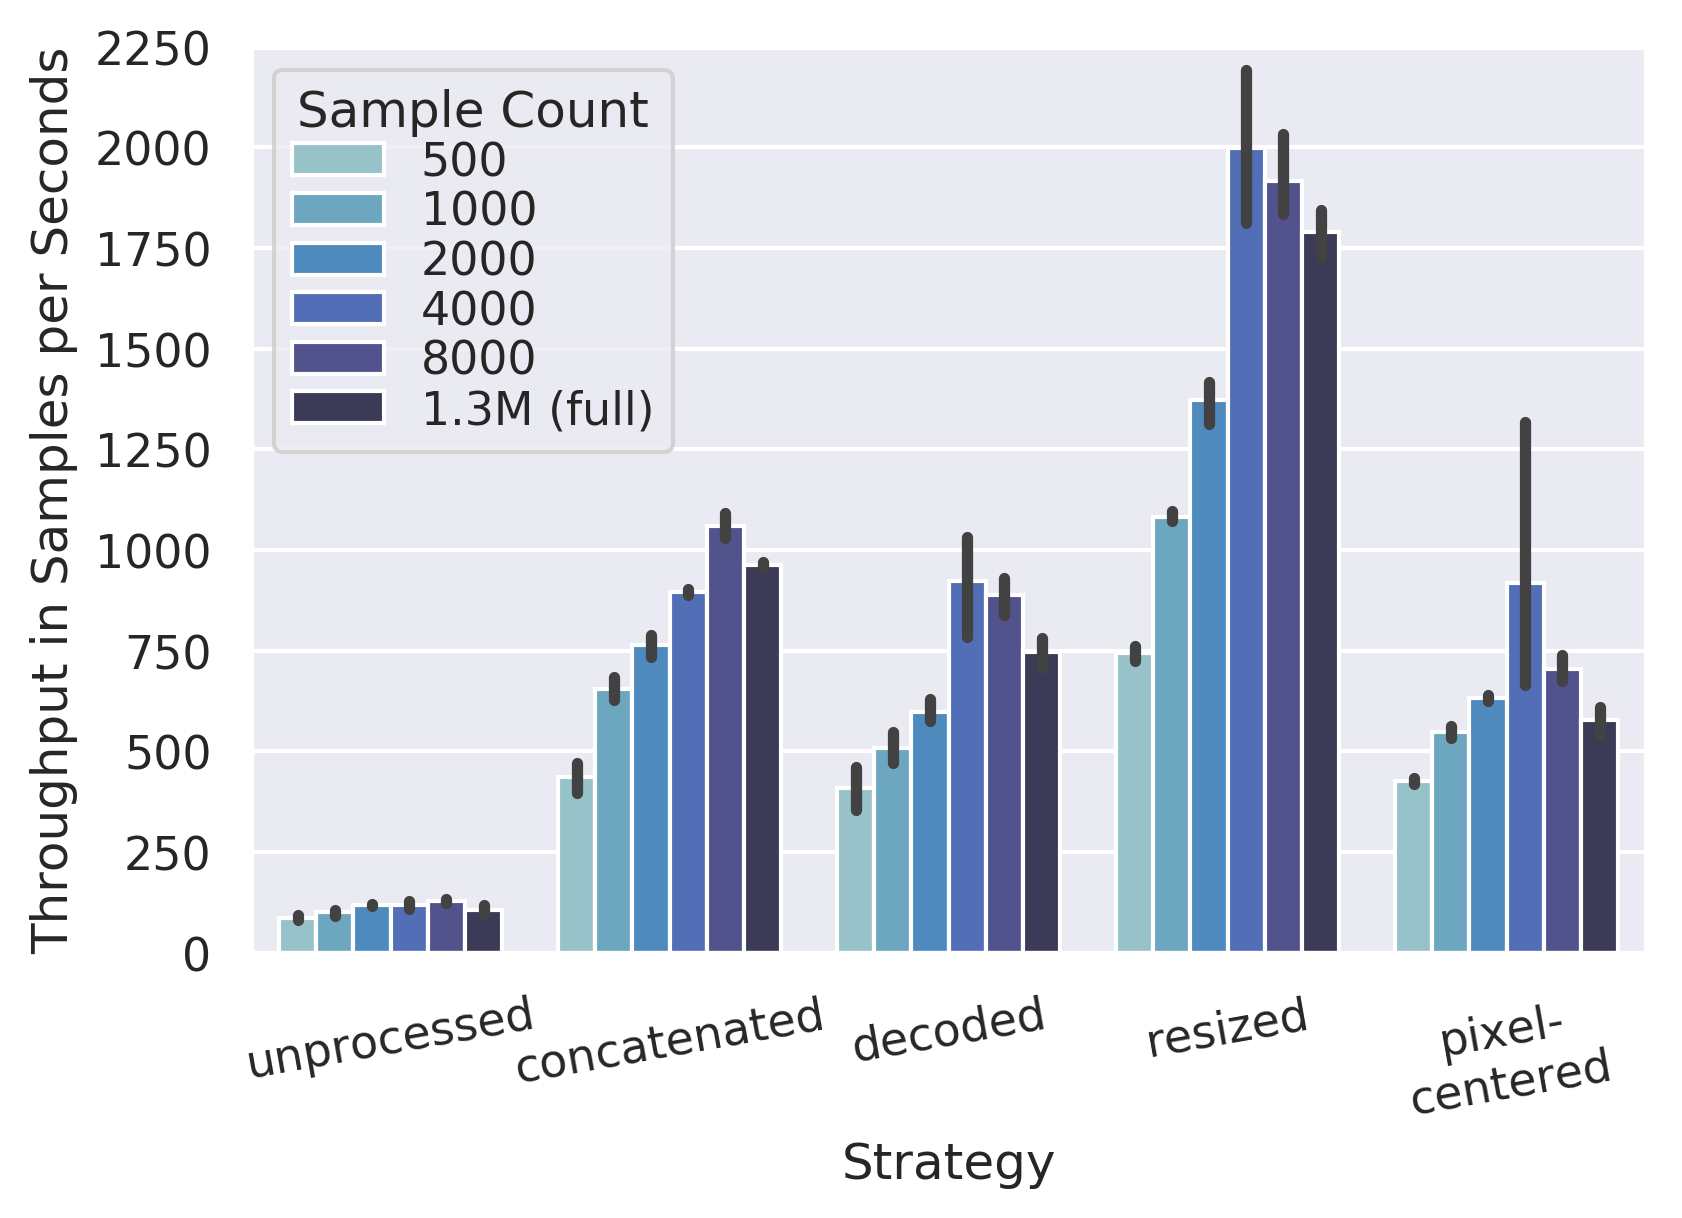

In [10]:
sns.set(palette=samples_palette)

cum_df_temp = cum_df_mod.query(f"runs_count==0 \
                             and thread_count==8")

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="sample_count",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 2250))
plot.legend(title="Sample Count", ncol=1, labelspacing=0.1)
save_fig("sampling-throughput")

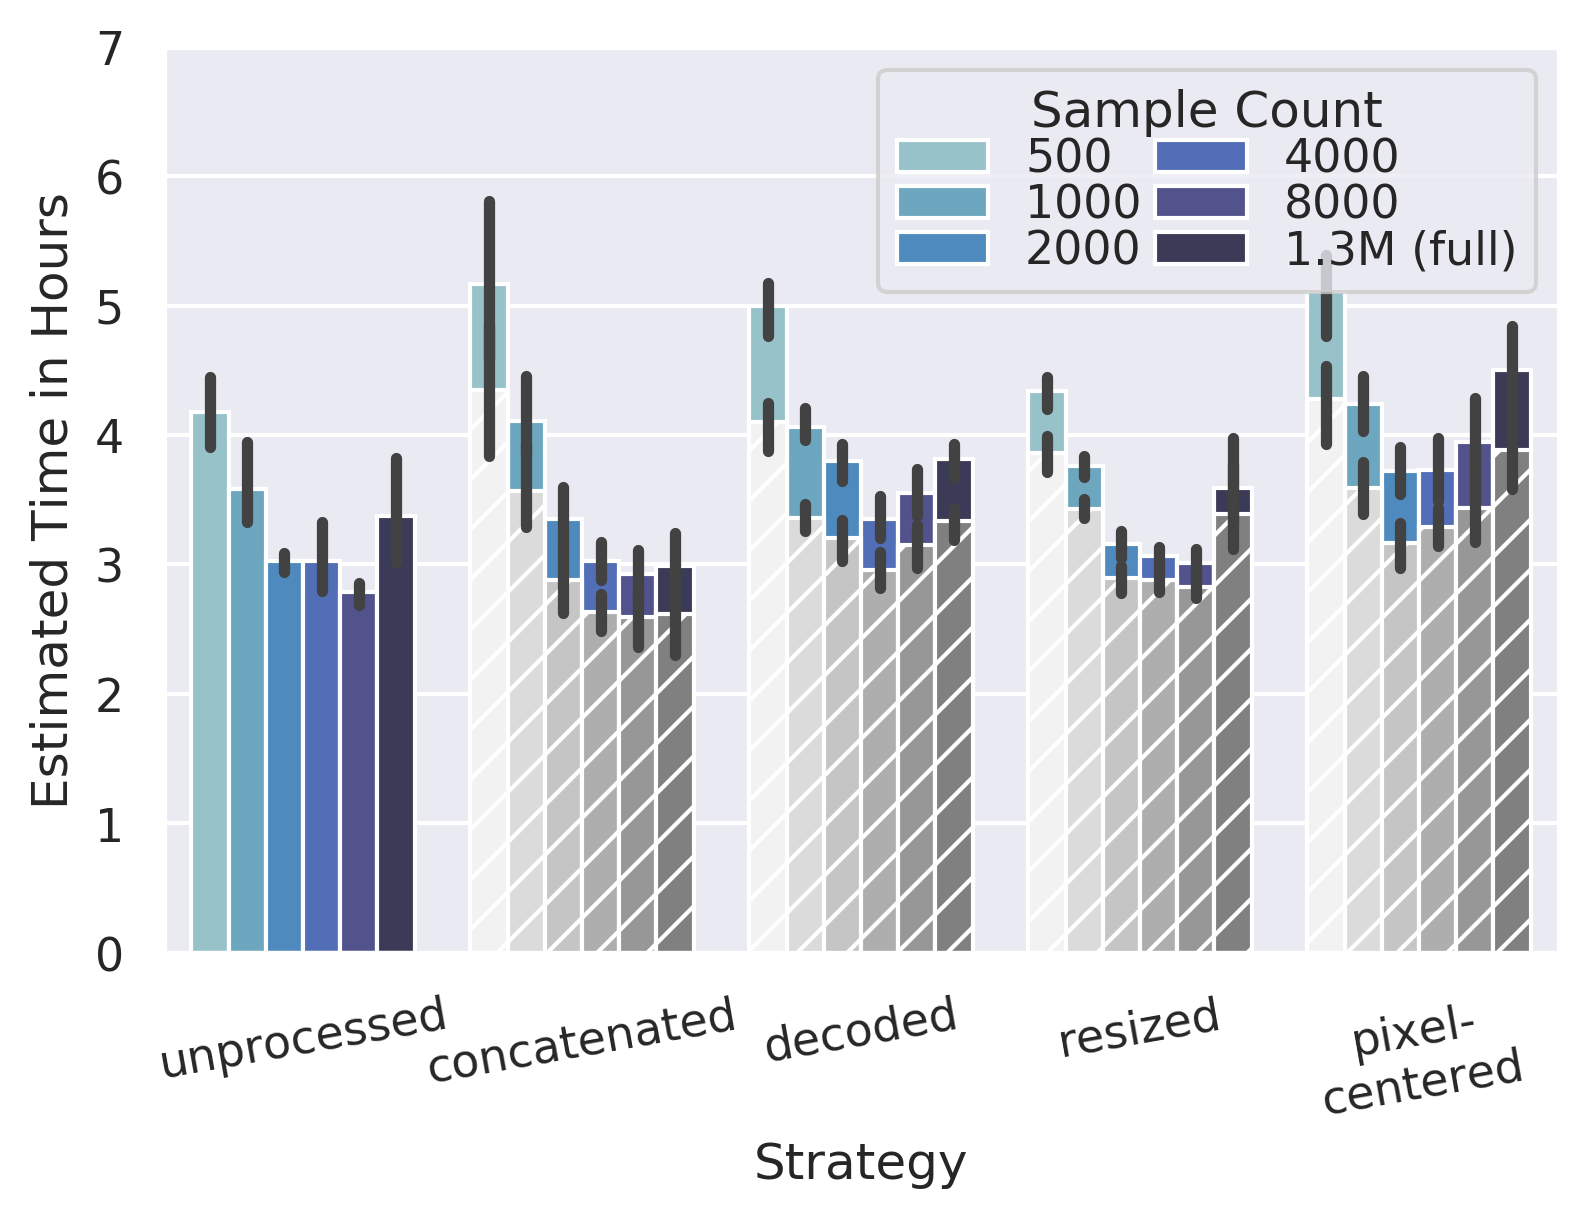

In [11]:
sns.set(palette=samples_palette)

cum_df_temp = cum_df_mod.query(f"runs_count==0 \
                             and thread_count==8")

plot = sns.barplot(
    x="split_name",
    y="full_dataset_processing_time_h",
    hue="sample_count",
    data=cum_df_temp
)
plot = sns.barplot(
    x="split_name",
    y="full_dataset_offline_processing_and_save_time_h",
    hue="sample_count",
    data=cum_df_temp,
    color="grey"
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)

sample_counts = len(cum_df_temp.sample_count.unique())
strategies_count = len(cum_df_temp.split_name.unique())

for i,bar in enumerate(plot.patches):
    if i > (sample_counts * strategies_count):
        bar.set_hatch("//")

plot.set(xlabel="Strategy", ylabel="Estimated Time in Hours")
plot.set(ylim=(0, 7))

handles, labels = plot.get_legend_handles_labels()
plot.legend(handles=handles[:sample_counts], title="Sample Count", loc="upper right", ncol=2, labelspacing=0.02, columnspacing=0.3)
save_fig("extrapolated-dataset-processing-time")

# 5. Speedup
## 8000 samples + 1, 2, 4, 8 threads + epoch 0
### Calculate the speedup 

In [12]:
cum_8000_df = cum_df_mod.query("sample_count==8000")

parallel_capability = {
      "thread_count": []
    , "strategy": []
    , "speedup": []
    , "run": []
}

def add_capability(thread_count, strategy, speedup, run):
    parallel_capability["thread_count"] += [thread_count]
    parallel_capability["strategy"] += [strategy]
    parallel_capability["speedup"] += [speedup]
    parallel_capability["run"] += [run]

for strategy in strategies:
    for run_count in cum_df.runs_count.unique():
        for thread_count in cum_df.thread_count.unique():
            throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].to_numpy()
            for throughput in throughputs:
                avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].mean()
                # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
                #if avg_step_t1_throughput < throughput:
                #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
                #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
                #else:
                #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
                #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
                ## now using speedup instead of increase/decrease factor
                speedup = throughput / avg_step_t1_throughput
                add_capability(thread_count, strategy, speedup, run_count)

parallel_capability_df = pd.DataFrame(parallel_capability)
parallel_capability_df

,thread_count,strategy,speedup,run
0,1,0-fully-online,1.049932,0
1,1,0-fully-online,1.005909,0
2,1,0-fully-online,0.993096,0
3,1,0-fully-online,0.975591,0
4,1,0-fully-online,0.975471,0
...,...,...,...,...
295,4,5-center-pixel-values,2.108041,1
296,4,5-center-pixel-values,2.317847,1
297,4,5-center-pixel-values,2.096757,1
298,4,5-center-pixel-values,2.113811,1


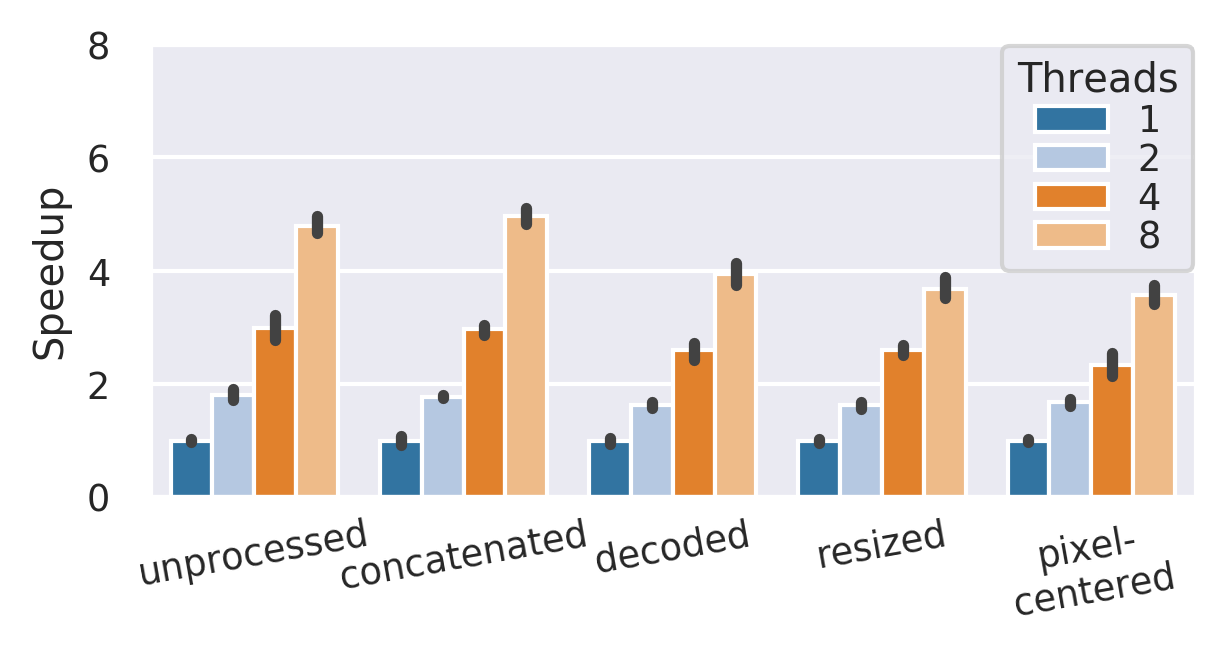

In [13]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==0")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 8))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-8000-samples-epoch-0")

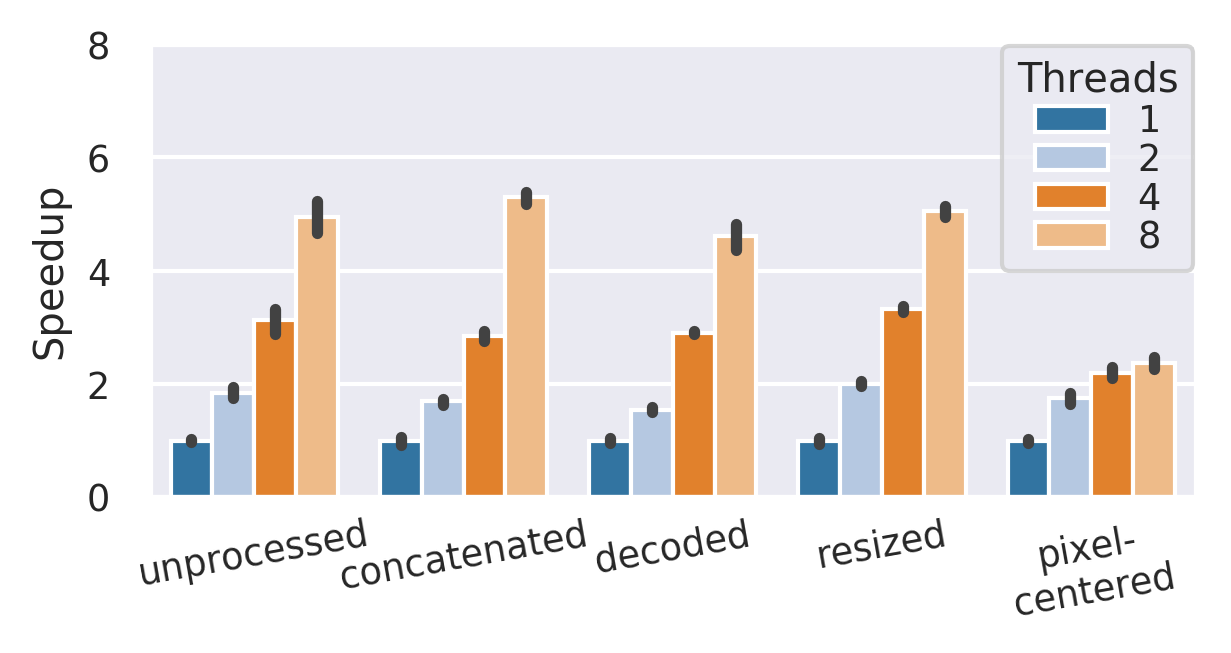

In [14]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==1")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 8))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-8000-samples-epoch-1")

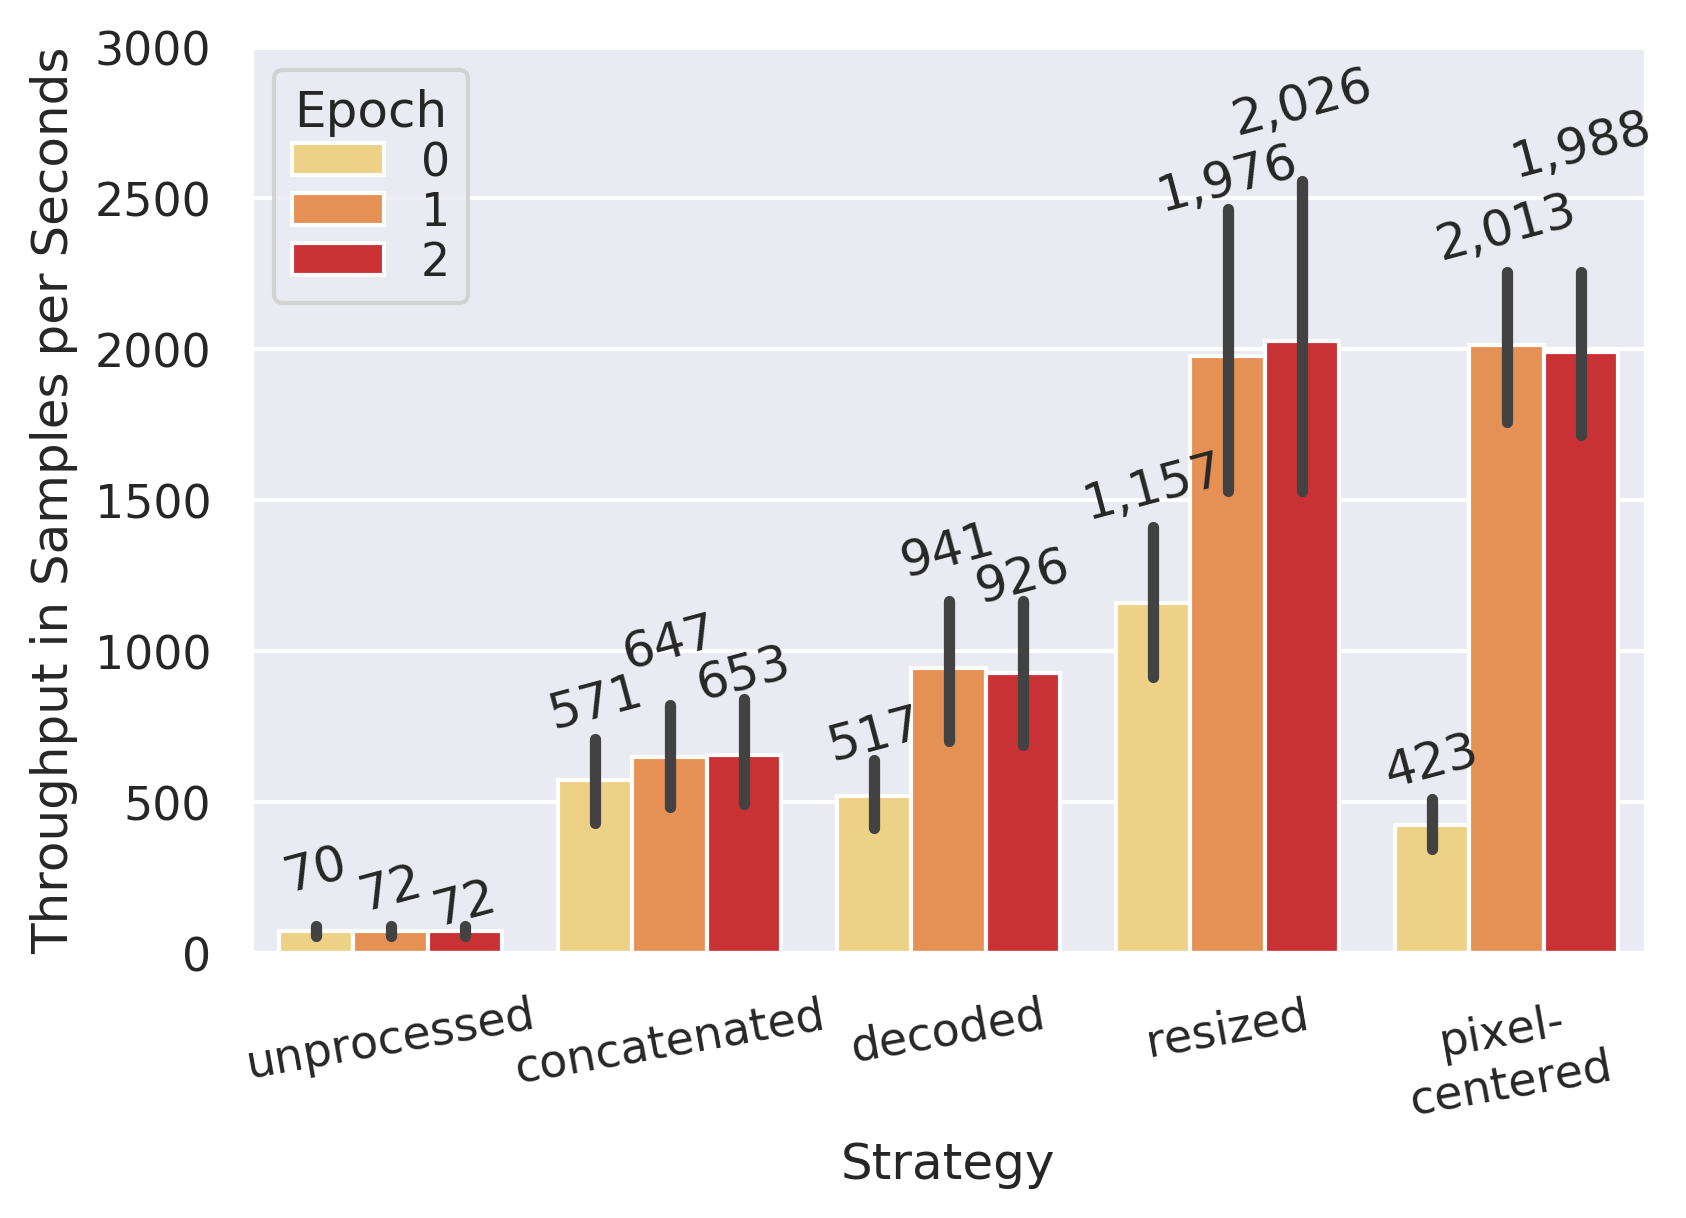

In [15]:
sns.set(palette=epoch_palette)
cum_df_temp = cum_df.query("sample_count==8000")

plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="Throughput in Samples per Seconds")
plot.set(ylim=(0, 3000))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1)
show_values_on_bars(plot, h_v="v", space=100, rotation=15, additional_space=[ 80,  150, 100, 300, 100
                                                                            , 20,  270, 280, 500, 300
                                                                            ,-30,  160, 210, 700, 600])
save_fig("throughput-8000-samples-epoch-0-1-2")

# X. Misc Plots and Calculations

## X.1 Calculation for the Introduction - unprocessed vs resized

In [26]:
unprocessed='0-fully-online'
concatenated='2-read-image'
resized='4-resize-image'
pixel_centered='5-center-pixel-values'
unprocessed_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{unprocessed}' and runs_count==0")["throughput_sps"].mean()
concatenated_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{concatenated}' and runs_count==0")["throughput_sps"].mean()
resized_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{resized}' and runs_count==0")["throughput_sps"].mean()
full_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{pixel_centered}' and runs_count==0")["throughput_sps"].mean()
print(f"Unprocessed    strategy throughput (8 threads):  {np.round(unprocessed_mean_throughput,0)} sps")
print(f"Concatenated   strategy throughput (8 threads):  {np.round(concatenated_mean_throughput,0)} sps")
print(f"Resized        strategy throughput (8 threads): {np.round(resized_mean_throughput,0)} sps")
print(f"Pixel-centered strategy throughput (8 threads):  {np.round(full_mean_throughput,0)} sps")

Unprocessed    strategy throughput (8 threads):  107.0 sps
Concatenated   strategy throughput (8 threads):  962.0 sps
Resized        strategy throughput (8 threads): 1790.0 sps
Pixel-centered strategy throughput (8 threads):  577.0 sps


## X.2 Calculation for Analysis - Network Throughput for Unprocessed vs Concatinated

In [17]:
run = 0
threads = 8
sample_count = full_dataset_samplecount

def extract_online_processing_frames(split_name):
    '''
    '''    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"].iloc[1])

---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 12158
12.287014961242676
---------------------------------------
-- 2-read-image Network Read in MB/s --
-- 2-read-image Online Processing time: 1331
111.27703094482422
---------------------------------------
-- 3-decode-image Network Read in MB/s --
-- 3-decode-image Online Processing time: 1722
490.6575927734375
---------------------------------------
-- 4-resize-image Network Read in MB/s --
-- 4-resize-image Online Processing time: 716
469.9493408203125
---------------------------------------
-- 5-center-pixel-values Network Read in MB/s --
-- 5-center-pixel-values Online Processing time: 2231
585.87841796875


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,61456.000000,61456.000000,61456.000000,61456.000000,61456.000000
mean,6115.019043,11.835742,1.124937,63.255825,23.778164
std,3728.200195,2.827317,0.406316,5.715010,3.948962
min,0.000000,0.000000,0.000000,35.242001,-10.861000
25%,2940.000000,9.975000,0.876000,59.449001,21.402000
50%,6012.500000,11.831000,1.126000,62.797001,23.899000
75%,9085.000000,13.819000,1.380000,66.456001,26.296000
max,15017.000000,24.090000,8.142000,106.741997,39.799999


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,3736.000000,3736.000000,3736.000000,3736.000000,3736.000000
mean,11035.107422,67.918060,2.976748,29.072939,0.016502
std,366.078064,6.020532,0.692407,5.830507,0.365117
min,10409.000000,0.000000,0.000000,16.730000,-3.275000
25%,10720.000000,65.601252,2.632000,25.664000,0.000000
50%,11031.000000,68.741997,2.911000,28.293500,0.000000
75%,11342.250000,71.248001,3.275000,31.572001,0.000000
max,11746.000000,80.376999,12.547000,96.490997,13.476000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,4708.000000,4708.000000,4708.000000,4708.000000,4708.000000
mean,13410.279297,43.435333,10.806701,43.974148,1.725290
std,404.672394,8.627759,2.060916,9.497391,1.428409
min,12798.000000,0.000000,0.000000,21.100000,-17.188999
25%,13078.750000,39.029999,9.637000,37.606251,0.881000
50%,13373.000000,44.395000,10.859000,42.839001,1.500000
75%,13667.000000,49.246499,12.171000,48.684499,2.351750
max,14450.000000,64.607002,19.497000,94.117996,22.528000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,741.000000,741.000000,741.000000,741.000000,741.000000
mean,15277.000000,49.856232,14.668409,34.565899,0.817688
std,214.052567,9.447732,2.110290,10.270963,1.226882
min,14907.000000,0.000000,5.000000,20.860001,-1.887000
25%,15092.000000,47.826000,13.699000,28.823999,0.127000
50%,15277.000000,52.146000,14.969000,32.035999,0.385000
75%,15462.000000,55.082001,16.010000,36.735001,1.134000
max,15647.000000,62.134998,25.344999,88.375000,16.250000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,4520.000000,4520.000000,4520.000000,4520.000000,4520.000000
mean,16740.697266,23.366339,14.907925,54.637680,7.016906
std,652.838562,6.231072,2.735295,8.212052,2.510004
min,15671.000000,0.000000,0.000000,31.830000,-6.076000
25%,16170.000000,19.471250,13.325000,49.367001,5.353750
50%,16735.000000,22.931999,15.197000,54.050999,6.863500
75%,17300.000000,27.321500,16.812250,59.344249,8.449000
max,17978.000000,45.026001,21.771999,99.750000,23.719999


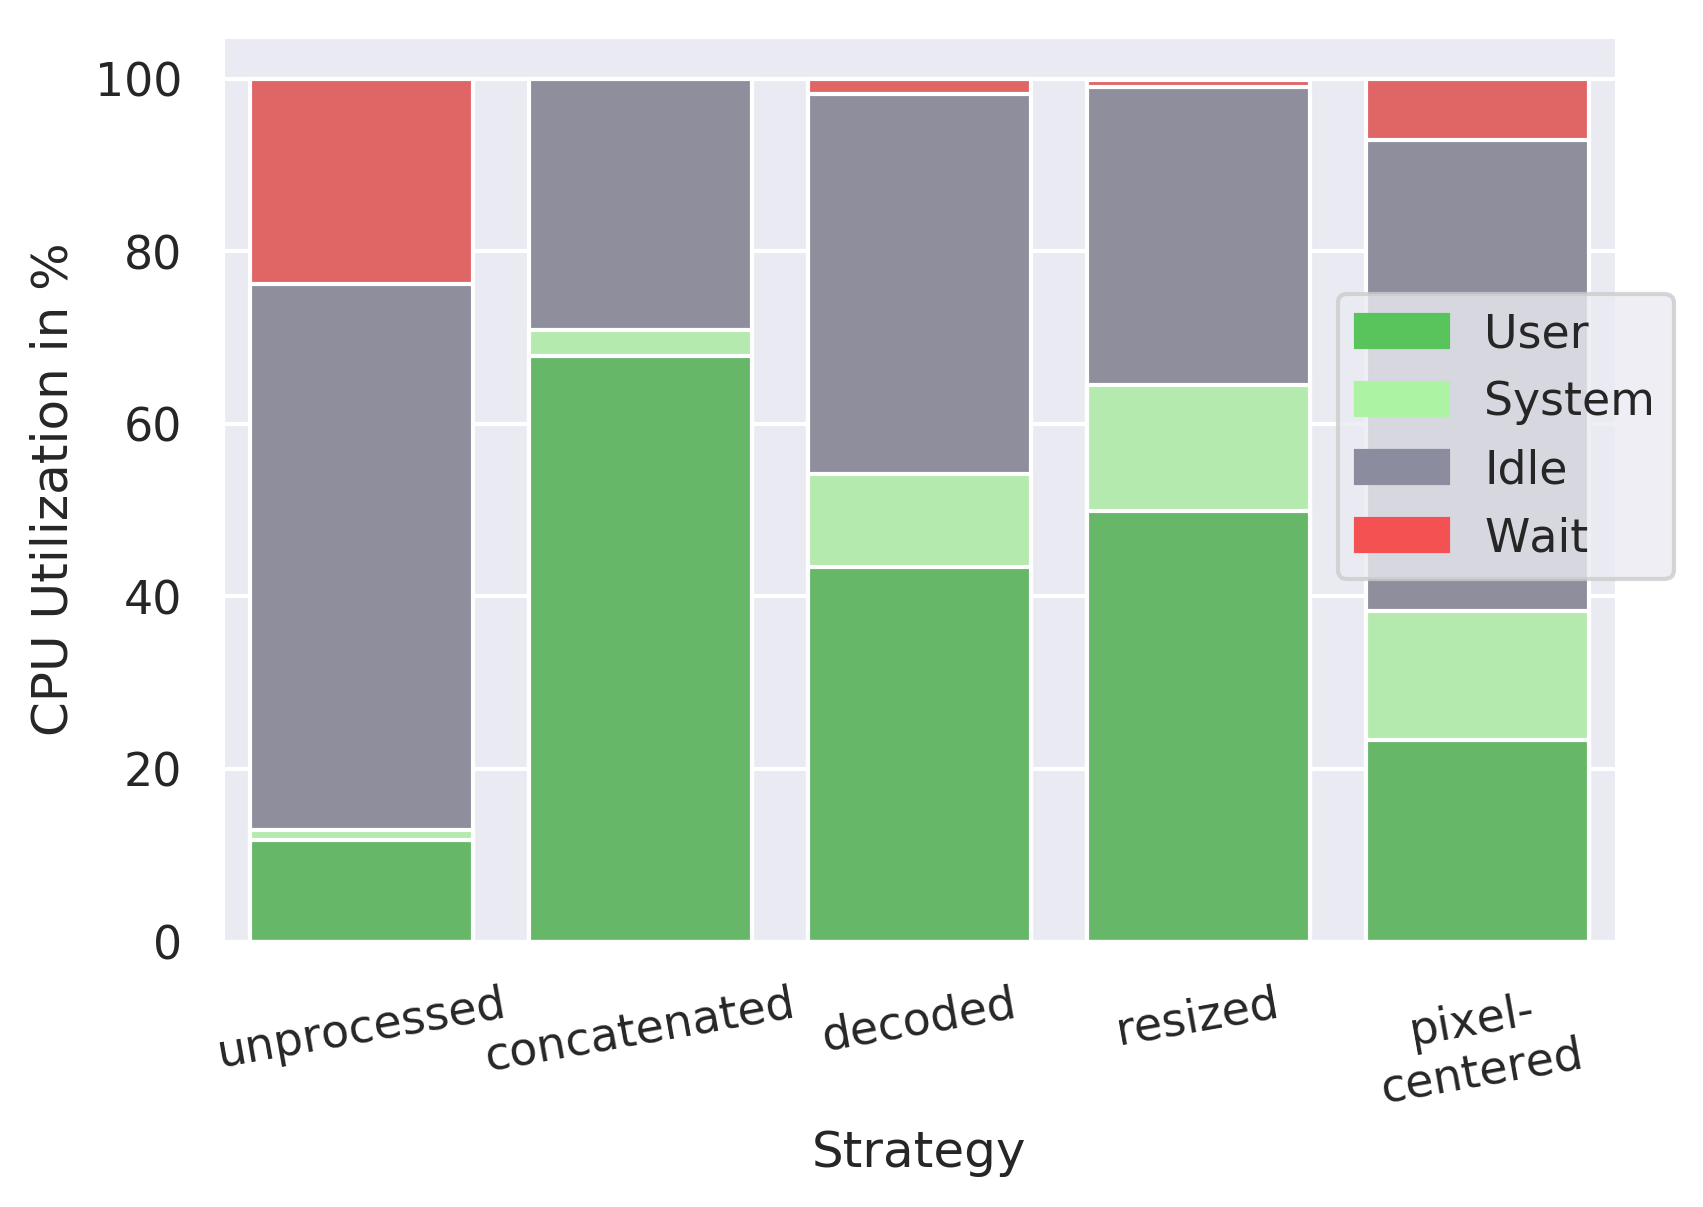

In [18]:
def extract_cpu_online_processing_time(split_name):
    '''
    '''
    run = 0
    threads = 8
    sample_count = full_dataset_samplecount
    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df[['rel_time_s','cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent','split_name']]

split_names = cum_df.split_name.unique()

frames = [extract_cpu_online_processing_time(split_name=split_name) for split_name in split_names]

online_cpu_df = pd.concat(frames)

def create_cumulative_and_aggregated_cpu_values(df):
    
    cpu_dict = {
        'split_name': []
      , 'cpu_usr_cum': []
      , 'cpu_sys_cum': []
      , 'cpu_idle_cum': []
      , 'cpu_wait_cum': []
    }
    
    def add_to_dict(split_name, usr, sys, idle, wait):
        cpu_dict['split_name'] += [split_name]
        cpu_dict['cpu_usr_cum'] += [usr]
        cpu_dict['cpu_sys_cum'] += [sys]
        cpu_dict['cpu_idle_cum'] += [idle]
        cpu_dict['cpu_wait_cum'] += [wait]
    
    for split_name in split_names:
        describe_df = df.query(f"split_name=='{split_name}'").describe()
        mean_df = describe_df.iloc[1] # get the mean
        mean_df['split_name'] = split_name
        mean_df['cpu_usr_sys_in_percent'] = mean_df['cpu_usr_in_percent'] \
                                          + mean_df['cpu_sys_in_percent']
        mean_df['cpu_usr_sys_idle_in_percent'] = mean_df['cpu_usr_sys_in_percent'] \
                                               + mean_df['cpu_idle_in_percent']
        mean_df['cpu_usr_sys_idle_wait_in_percent'] = mean_df['cpu_usr_sys_idle_in_percent'] \
                                                    + mean_df['cpu_wait_in_percent']

        mean_df['cpu_usr_cum'] = mean_df['cpu_usr_in_percent']
        mean_df['cpu_sys_cum'] = mean_df['cpu_usr_sys_in_percent']
        mean_df['cpu_idle_cum'] = mean_df['cpu_usr_sys_idle_in_percent']
        mean_df['cpu_wait_cum'] = mean_df['cpu_usr_sys_idle_wait_in_percent']
        add_to_dict(split_name=split_name, usr=mean_df['cpu_usr_cum']
                   ,sys=mean_df['cpu_sys_cum']
                   ,idle=mean_df['cpu_idle_cum']
                   ,wait=mean_df['cpu_wait_cum'])
        display(describe_df)

    return pd.DataFrame(cpu_dict)
    
cumulative_cpu_df = create_cumulative_and_aggregated_cpu_values(df=online_cpu_df)

green1 = "#5AC45C"
green2 = "#acf4a3"
grey = "#8c8c9f"
red = "#f45252"

bar4 = sns.barplot(x="split_name",  y="cpu_wait_cum", data=cumulative_cpu_df, color=red)
bar3 = sns.barplot(x="split_name",  y="cpu_idle_cum", data=cumulative_cpu_df, color=grey)
bar2 = sns.barplot(x="split_name",  y="cpu_sys_cum", data=cumulative_cpu_df, color=green2)
bar1 = sns.barplot(x="split_name",  y="cpu_usr_cum", data=cumulative_cpu_df, color=green1)
plot = bar1

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="CPU Utilization in %")

# add legend
legend_bar1 = mpatches.Patch(color=green1, label='User')
legend_bar2 = mpatches.Patch(color=green2, label='System')
legend_bar3 = mpatches.Patch(color=grey, label='Idle')
legend_bar4 = mpatches.Patch(color=red, label='Wait')
plt.legend(handles=[legend_bar1,legend_bar2,legend_bar3,legend_bar4], loc=(0.8,0.4))

,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,15018.000000,15018.000000,15018.000000,15018.000000,15018.000000
mean,7508.500000,9.744176,0.885977,62.961781,26.404024
std,4335.467285,1.842238,0.304964,5.146403,3.766878
min,0.000000,0.000000,0.000000,41.887001,0.004000
25%,3754.250000,8.657000,0.631000,59.497002,24.212000
50%,7508.500000,9.912000,0.878000,62.530998,26.600000
75%,11262.750000,11.028000,1.118500,65.829002,28.931000
max,15017.000000,16.855000,4.025000,99.956001,39.799999


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000
mean,11077.500000,67.384766,2.97191,29.586943,0.040688
std,386.391632,8.170869,0.93107,7.592018,0.585966
min,10409.000000,0.000000,0.00000,17.146000,-1.633000
25%,10743.250000,65.425499,2.62200,25.828000,0.000000
50%,11077.500000,68.647499,2.90000,28.454000,0.000000
75%,11411.750000,71.176003,3.25000,31.742500,0.000000
max,11746.000000,80.224998,12.54700,96.490997,13.476000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000
mean,11969.000977,42.960464,12.083580,43.198078,1.678643
std,509.078583,9.416759,2.252332,10.505068,1.670583
min,11088.000000,0.000000,0.000000,23.048000,-26.441000
25%,11528.500000,39.571501,11.083000,36.762001,0.874500
50%,11969.000000,44.640999,12.330000,41.301998,1.380000
75%,12409.500000,48.639999,13.452000,47.344999,2.144000
max,12850.000000,60.799000,25.063000,87.610001,12.516000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,695.000000,695.000000,695.000000,695.000000,695.000000
mean,11623.000000,53.388378,11.382115,34.503506,0.679709
std,200.773499,11.288633,1.837900,11.762455,1.245779
min,11276.000000,0.000000,2.239000,17.816999,-6.888000
25%,11449.500000,51.289000,10.660000,27.785000,0.124000
50%,11623.000000,55.799000,11.667000,32.138000,0.253000
75%,11796.500000,59.657000,12.492000,36.832500,1.010500
max,11970.000000,71.446999,17.610001,87.500000,10.263000


,rel_time_s,cpu_usr_in_percent,cpu_sys_in_percent,cpu_idle_in_percent,cpu_wait_in_percent
count,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000
mean,16498.500000,22.721987,15.255469,54.573376,7.373434
std,723.564209,5.721790,2.596523,7.855466,2.599343
min,15246.000000,0.000000,0.876000,34.615002,-1.880000
25%,15872.250000,19.448000,13.802000,49.621249,5.653000
50%,16498.500000,22.528000,15.550000,53.773500,7.241000
75%,17124.750000,26.242001,17.026250,58.775249,8.906000
max,17751.000000,42.020000,32.020000,99.750000,23.719999


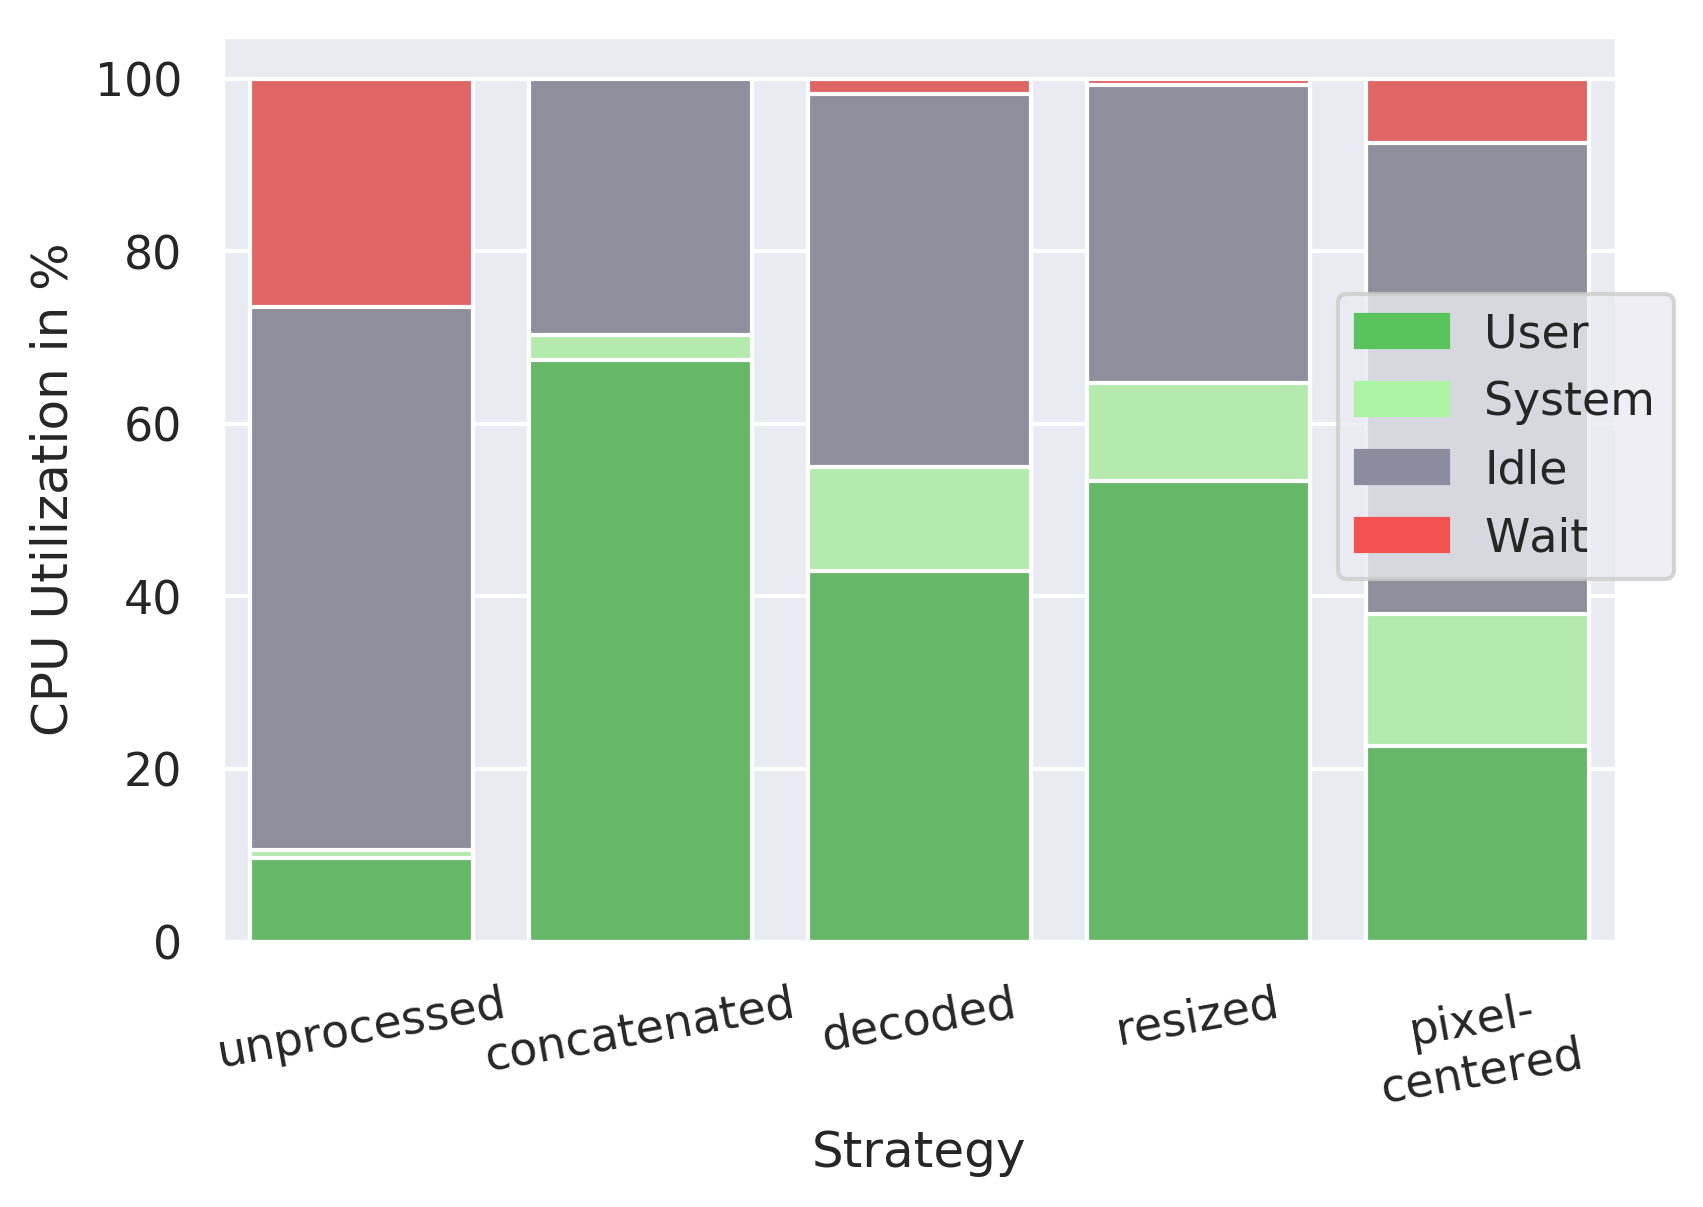

In [19]:
def extract_cpu_online_processing_time(split_name):
    '''
    '''
    run = 0
    threads = 8
    sample_count = full_dataset_samplecount


    experiment_df = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}").head(1)

    # picking one experiment
    ueid = experiment_df['ueid'].iloc[0]
    offline_processing_time_s = experiment_df["offline_processing_and_save_time_s"].iloc[0]

    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          ueid=='{ueid}' and \
          rel_time_s>={offline_processing_time_s}")
    
    return filtered_dstat_df[['rel_time_s','cpu_usr_in_percent',
       'cpu_sys_in_percent', 'cpu_idle_in_percent', 'cpu_wait_in_percent','split_name']]
    

split_names = cum_df.split_name.unique()
frames = [extract_cpu_online_processing_time(split_name=split_name) for split_name in split_names]
online_cpu_df = pd.concat(frames)

def create_cumulative_and_aggregated_cpu_values(df):
    
    cpu_dict = {
        'split_name': []
      , 'cpu_usr_cum': []
      , 'cpu_sys_cum': []
      , 'cpu_idle_cum': []
      , 'cpu_wait_cum': []
    }
    
    def add_to_dict(split_name, usr, sys, idle, wait):
        cpu_dict['split_name'] += [split_name]
        cpu_dict['cpu_usr_cum'] += [usr]
        cpu_dict['cpu_sys_cum'] += [sys]
        cpu_dict['cpu_idle_cum'] += [idle]
        cpu_dict['cpu_wait_cum'] += [wait]
    
    for split_name in split_names:
        describe_df = df.query(f"split_name=='{split_name}'").describe()
        mean_df = describe_df.iloc[1] # get the mean
        mean_df['split_name'] = split_name
        mean_df['cpu_usr_sys_in_percent'] = mean_df['cpu_usr_in_percent'] \
                                          + mean_df['cpu_sys_in_percent']
        mean_df['cpu_usr_sys_idle_in_percent'] = mean_df['cpu_usr_sys_in_percent'] \
                                               + mean_df['cpu_idle_in_percent']
        mean_df['cpu_usr_sys_idle_wait_in_percent'] = mean_df['cpu_usr_sys_idle_in_percent'] \
                                                    + mean_df['cpu_wait_in_percent']

        mean_df['cpu_usr_cum'] = mean_df['cpu_usr_in_percent']
        mean_df['cpu_sys_cum'] = mean_df['cpu_usr_sys_in_percent']
        mean_df['cpu_idle_cum'] = mean_df['cpu_usr_sys_idle_in_percent']
        mean_df['cpu_wait_cum'] = mean_df['cpu_usr_sys_idle_wait_in_percent']
        add_to_dict(split_name=split_name, usr=mean_df['cpu_usr_cum']
                   ,sys=mean_df['cpu_sys_cum']
                   ,idle=mean_df['cpu_idle_cum']
                   ,wait=mean_df['cpu_wait_cum'])
        display(describe_df)

    return pd.DataFrame(cpu_dict)
    
cumulative_cpu_df = create_cumulative_and_aggregated_cpu_values(df=online_cpu_df)

green1 = "#5AC45C"
green2 = "#acf4a3"
grey = "#8c8c9f"
red = "#f45252"

bar4 = sns.barplot(x="split_name",  y="cpu_wait_cum", data=cumulative_cpu_df, color=red)
bar3 = sns.barplot(x="split_name",  y="cpu_idle_cum", data=cumulative_cpu_df, color=grey)
bar2 = sns.barplot(x="split_name",  y="cpu_sys_cum", data=cumulative_cpu_df, color=green2)
bar1 = sns.barplot(x="split_name",  y="cpu_usr_cum", data=cumulative_cpu_df, color=green1)
plot = bar1

plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.set(xlabel="Strategy", ylabel="CPU Utilization in %")

# add legend
legend_bar1 = mpatches.Patch(color=green1, label='User')
legend_bar2 = mpatches.Patch(color=green2, label='System')
legend_bar3 = mpatches.Patch(color=grey, label='Idle')
legend_bar4 = mpatches.Patch(color=red, label='Wait')
plt.legend(handles=[legend_bar1,legend_bar2,legend_bar3,legend_bar4], loc=(0.8,0.4))

## X.2 Warning - Creating the plots based on `dstat` logs can take several hours

In [20]:
cum_dstat_df_copy = cum_dstat_df.copy(deep=True)
cum_dstat_df_copy["sample_count"] = cum_dstat_df_copy.sample_count.astype('category')
cum_dstat_df_copy["split_name"] = cum_dstat_df_copy.split_name.astype('category')
cum_dstat_df_copy["run"] = cum_dstat_df_copy.run.astype('category')
cum_dstat_df_copy["thread_count"] = cum_dstat_df_copy.thread_count.astype('category')
strategy_list = list(cum_dstat_df_copy.split_name.unique())
strategy_list

['0-fully-online',
 '2-read-image',
 '3-decode-image',
 '4-resize-image',
 '5-center-pixel-values']

In [21]:
test_df = cum_df.query(f"sample_count=={full_dataset_samplecount} and \
               thread_count==8 and \
               split_name=='3-decode-image' and \
               runs_count==0")

display(test_df["per_sample_online_processing_time_s"].describe())
display(((test_df["shard_cum_size_MB"] / full_dataset_samplecount)).describe())

per_sample_time_s = test_df["per_sample_online_processing_time_s"].describe().iloc[1]
per_sample_size_mb = (test_df["shard_cum_size_MB"] / full_dataset_samplecount).describe().iloc[1]

per_sample_size_mb / per_sample_time_s

count    5.000000
mean     0.001344
std      0.000096
min      0.001265
25%      0.001275
50%      0.001320
75%      0.001360
max      0.001502
Name: per_sample_online_processing_time_s, dtype: float64

count    5.00000
mean     0.65759
std      0.00000
min      0.65759
25%      0.65759
50%      0.65759
75%      0.65759
max      0.65759
Name: shard_cum_size_MB, dtype: float64

489.19540756525123

In [22]:
run = 0
threads = 8
sample_count = full_dataset_samplecount

def extract_online_processing_frames(split_name):
    '''
    '''    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"])

---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 12158
count    61456.000000
mean        12.287015
std          3.232788
min          0.000000
25%         10.119009
50%         12.235641
75%         14.490305
max         32.183697
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 2-read-image Network Read in MB/s --
-- 2-read-image Online Processing time: 1331
count    3736.000000
mean      111.277031
std        16.731785
min         0.000120
25%       100.995800
50%       112.060658
75%       123.086603
max       193.587326
Name: net_read_mbs, dtype: float64
---------------------------------------
-- 3-decode-image Network Read in MB/s --
-- 3-decode-image Online Processing time: 1722
count    4708.000000
mean      490.657593
std       100.775169
min         0.000060
25%       435.117821
50%       500.746201
75%       558.614243
max       758.852539
Name: net_read_mbs, dtype: float64

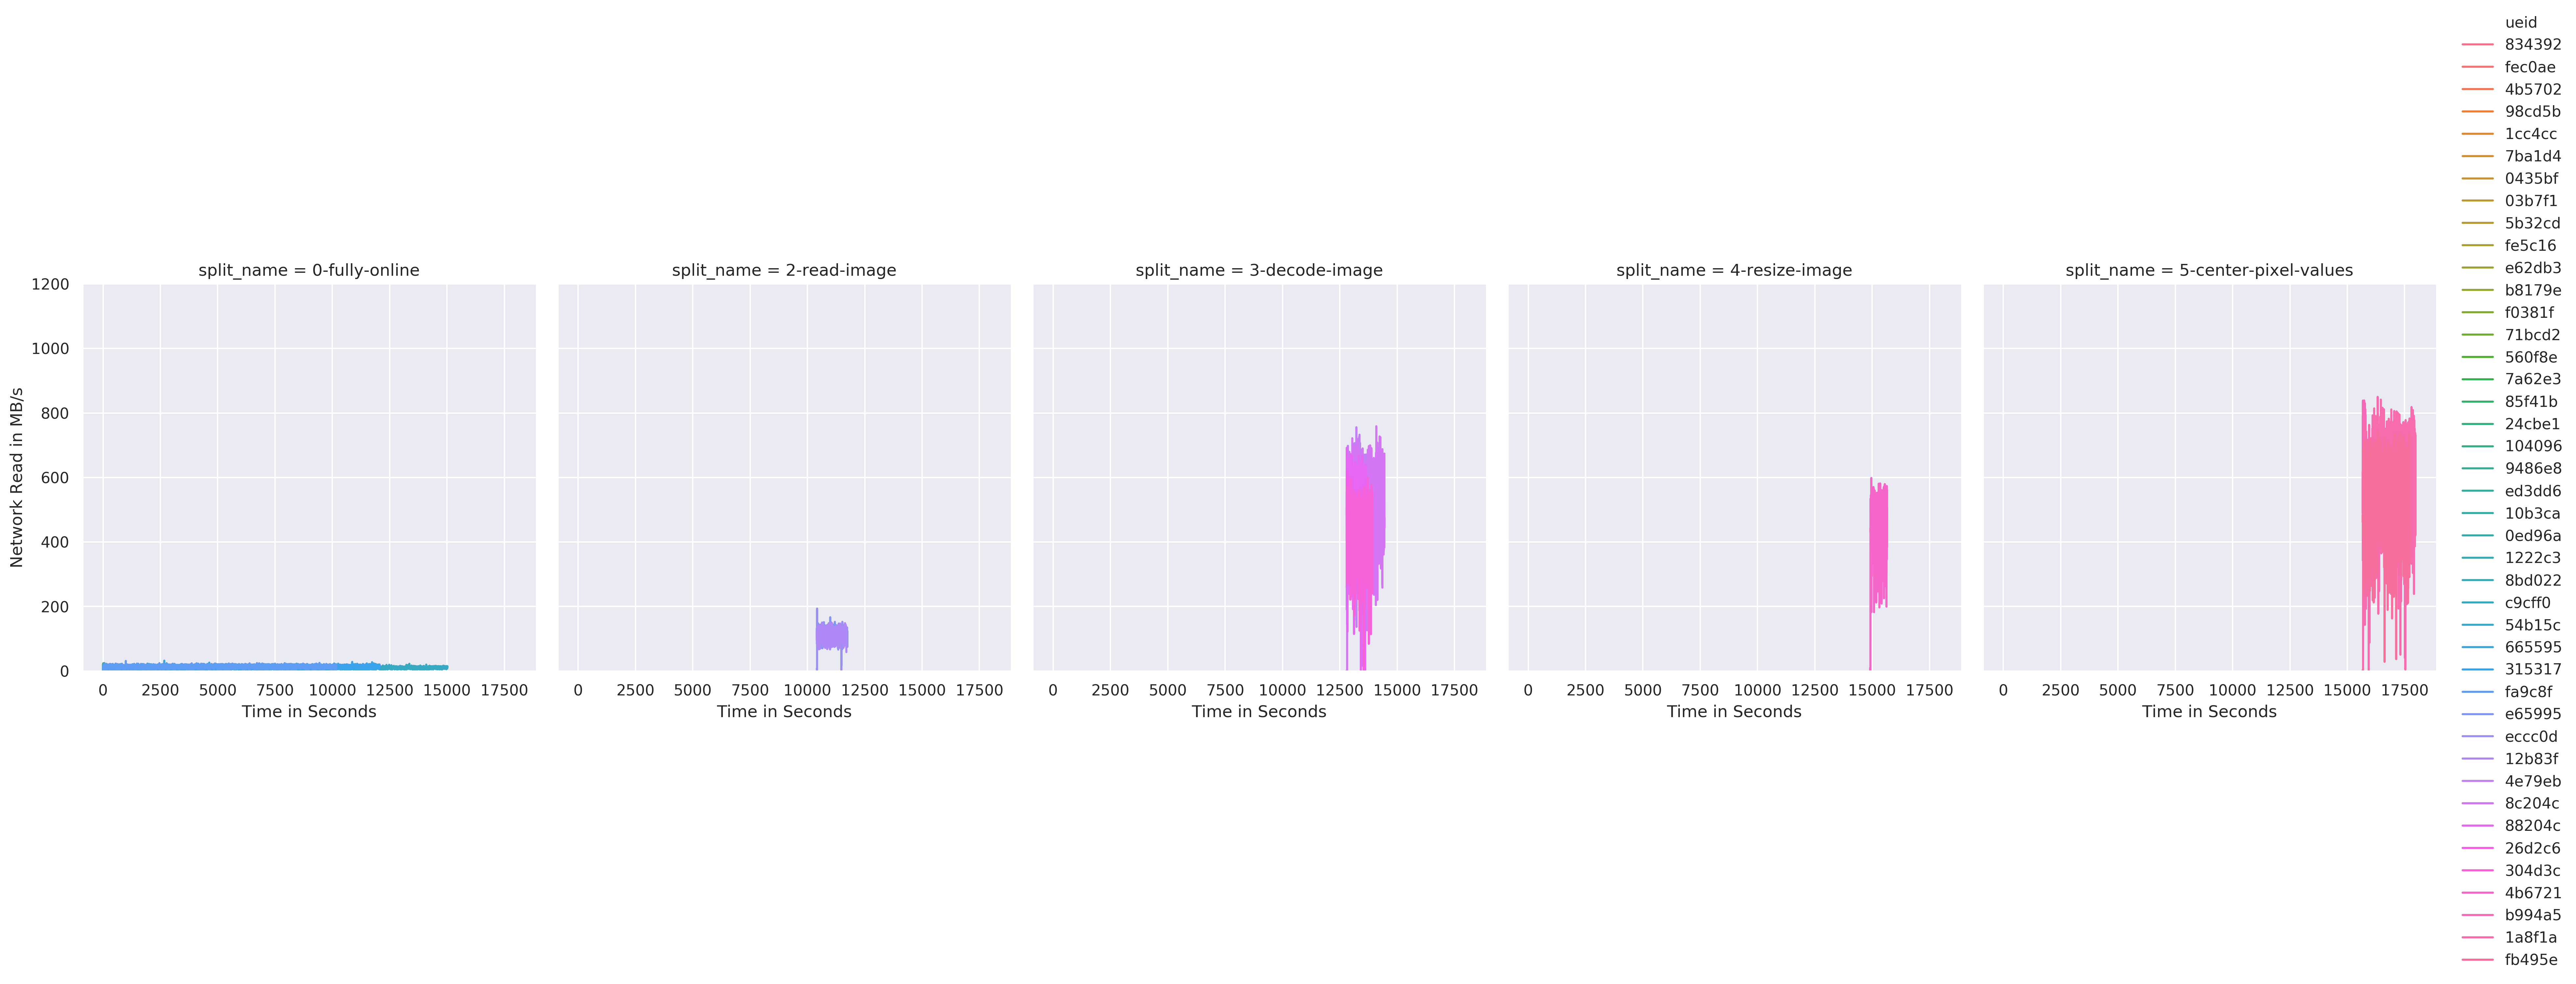

In [12]:
sns.set(palette=default_palette)

plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    hue="ueid",
    col="split_name",
    kind="line",
    data=online_df,
    #ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")
plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

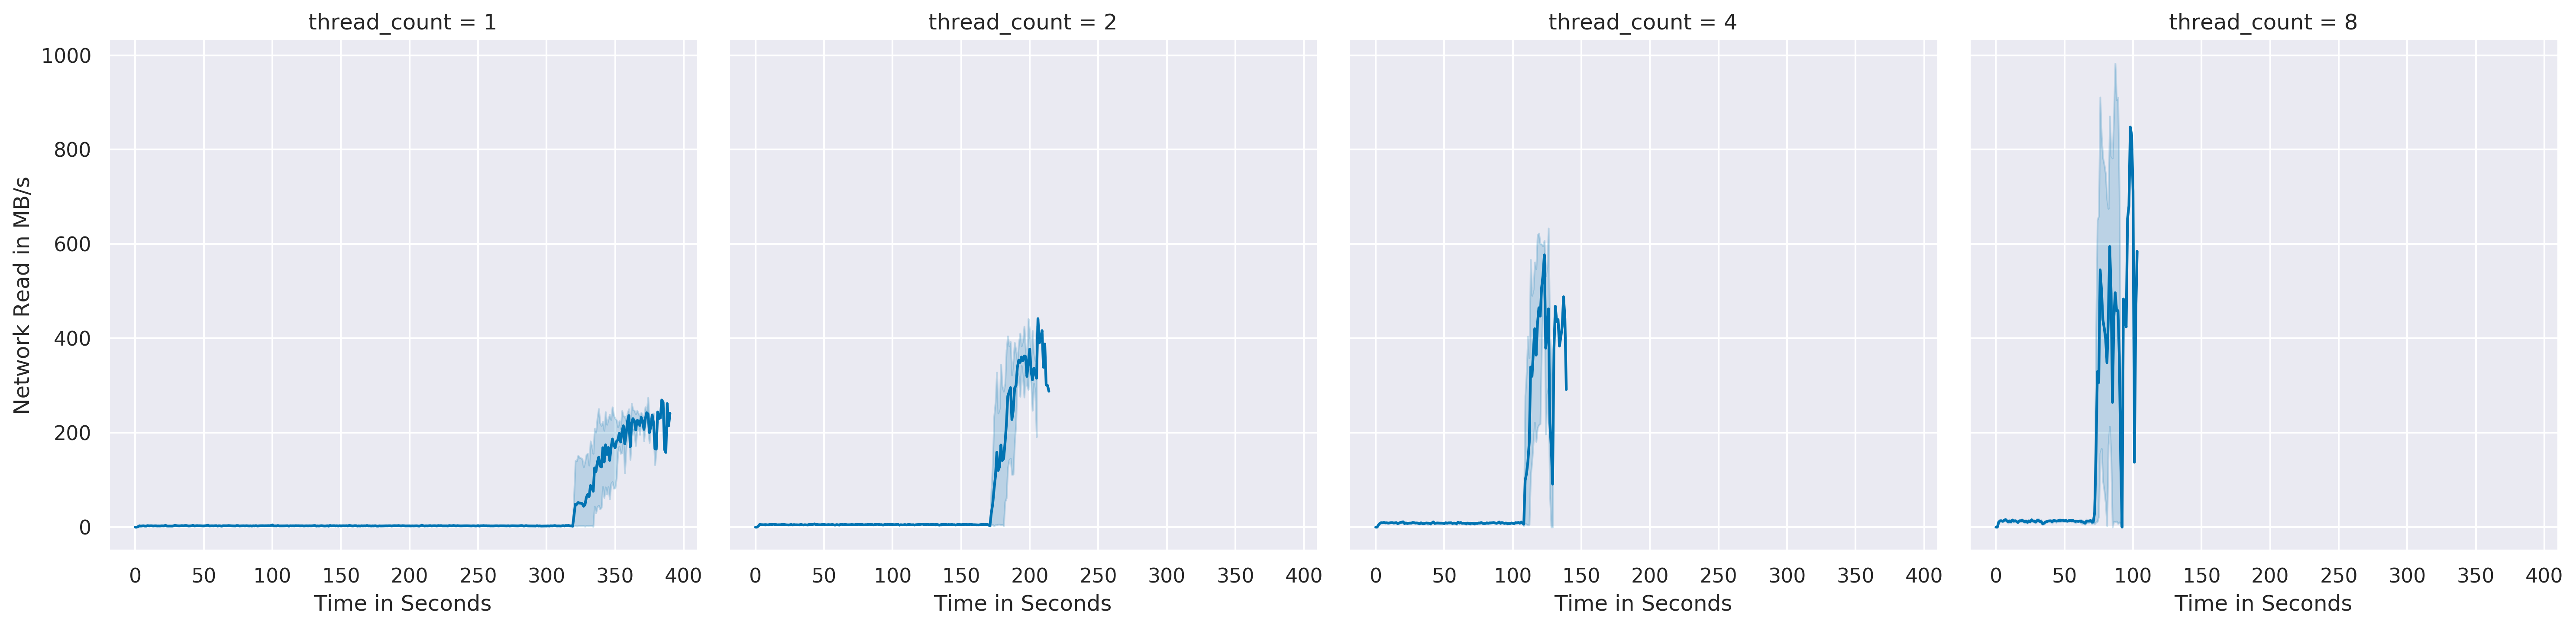

In [68]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={8000} and \
                                              run==0")
plot = sns.relplot(
    x="rel_time_s",
    y="net_read_mbs",
    col="thread_count",
    kind="line",
    data=cum_dstat_df_temp.query("split_name=='5-center-pixel-values'"),
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Network Read in MB/s")

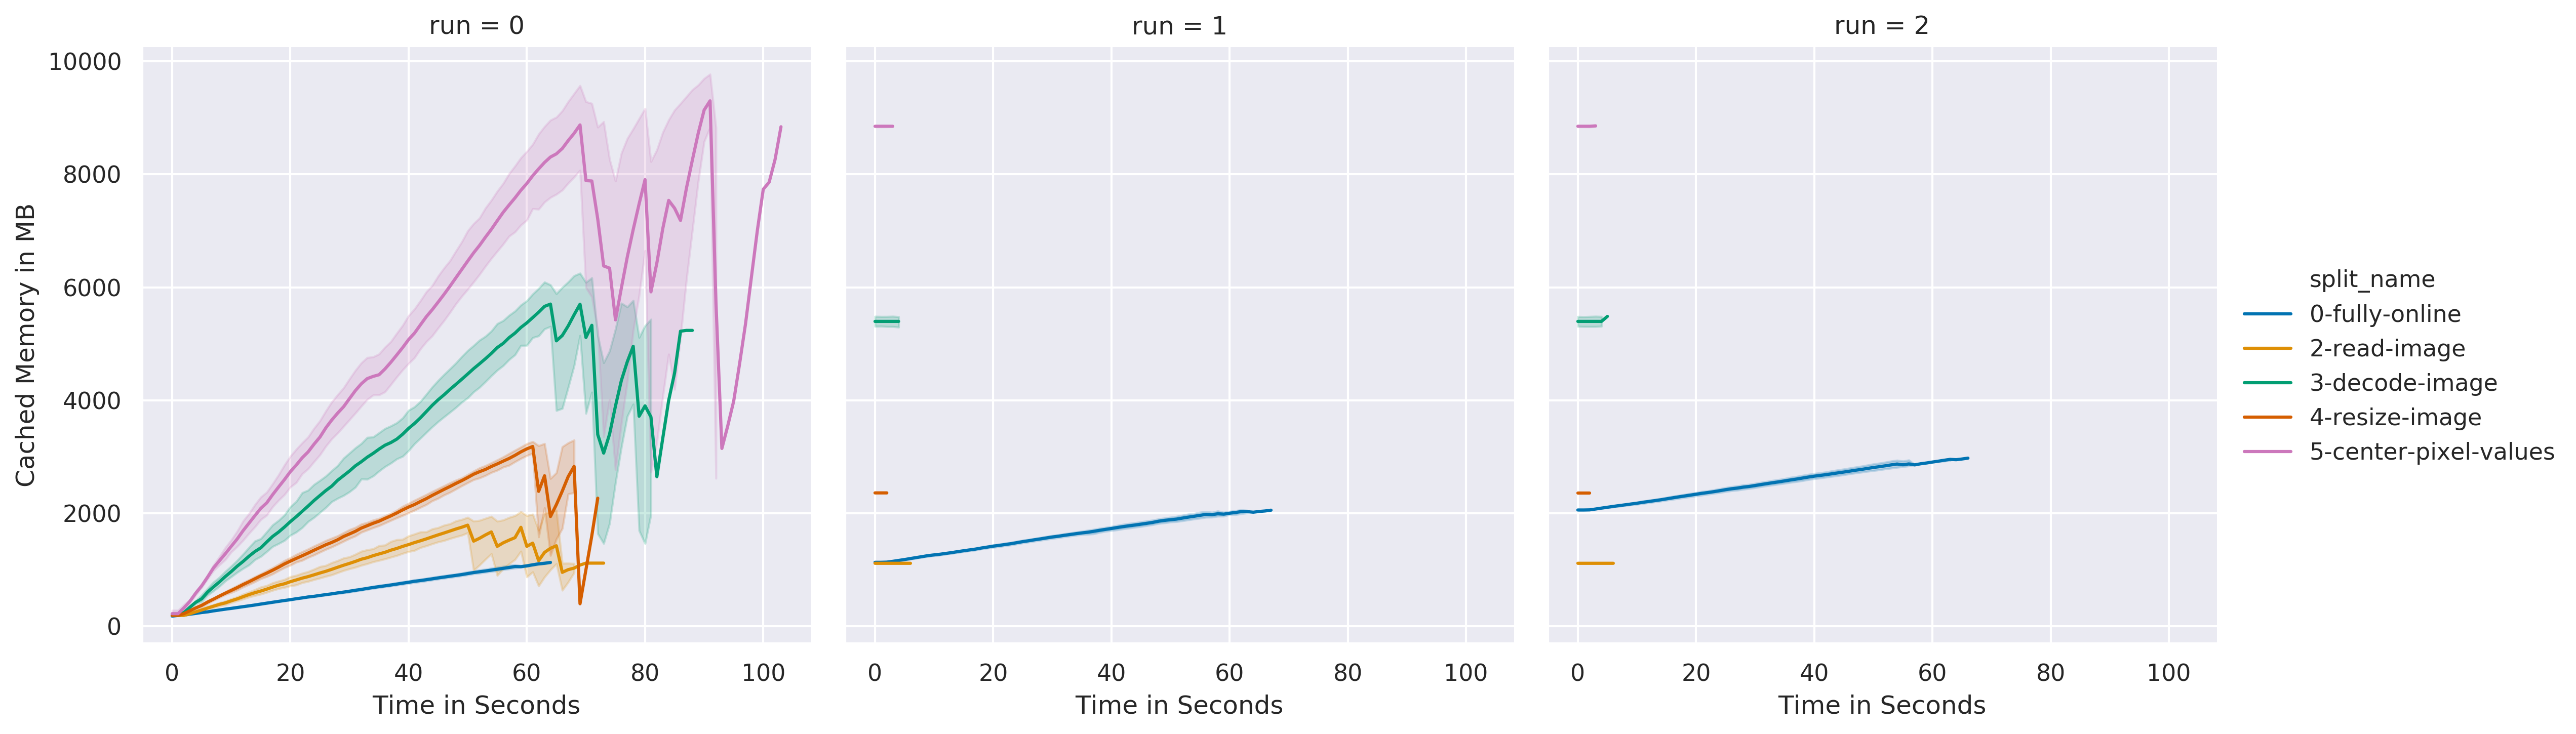

In [194]:
sns.set(palette=default_palette)

cum_dstat_df_temp = cum_dstat_df_copy.query(f"sample_count=={8000} and \
                                              thread_count==8")
plot = sns.relplot(
    x="rel_time_s",
    y="memory_cached_mb",
    hue="split_name",
    col="run",
    kind="line",
    data=cum_dstat_df_temp,
    ci=95
)
plot.set(xlabel="Time in Seconds", ylabel="Cached Memory in MB")
#plot.set(ylim=(0, 1200))
#plot.axhline(1100, color="black")
#plot.legend(strategies_renamed, title="Strategy", loc="upper right", ncol=1,labelspacing=0.10)
#save_fig("network-read-speed-t8-full", file_type="png")

/home/asa/.miniconda/envs/presto/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


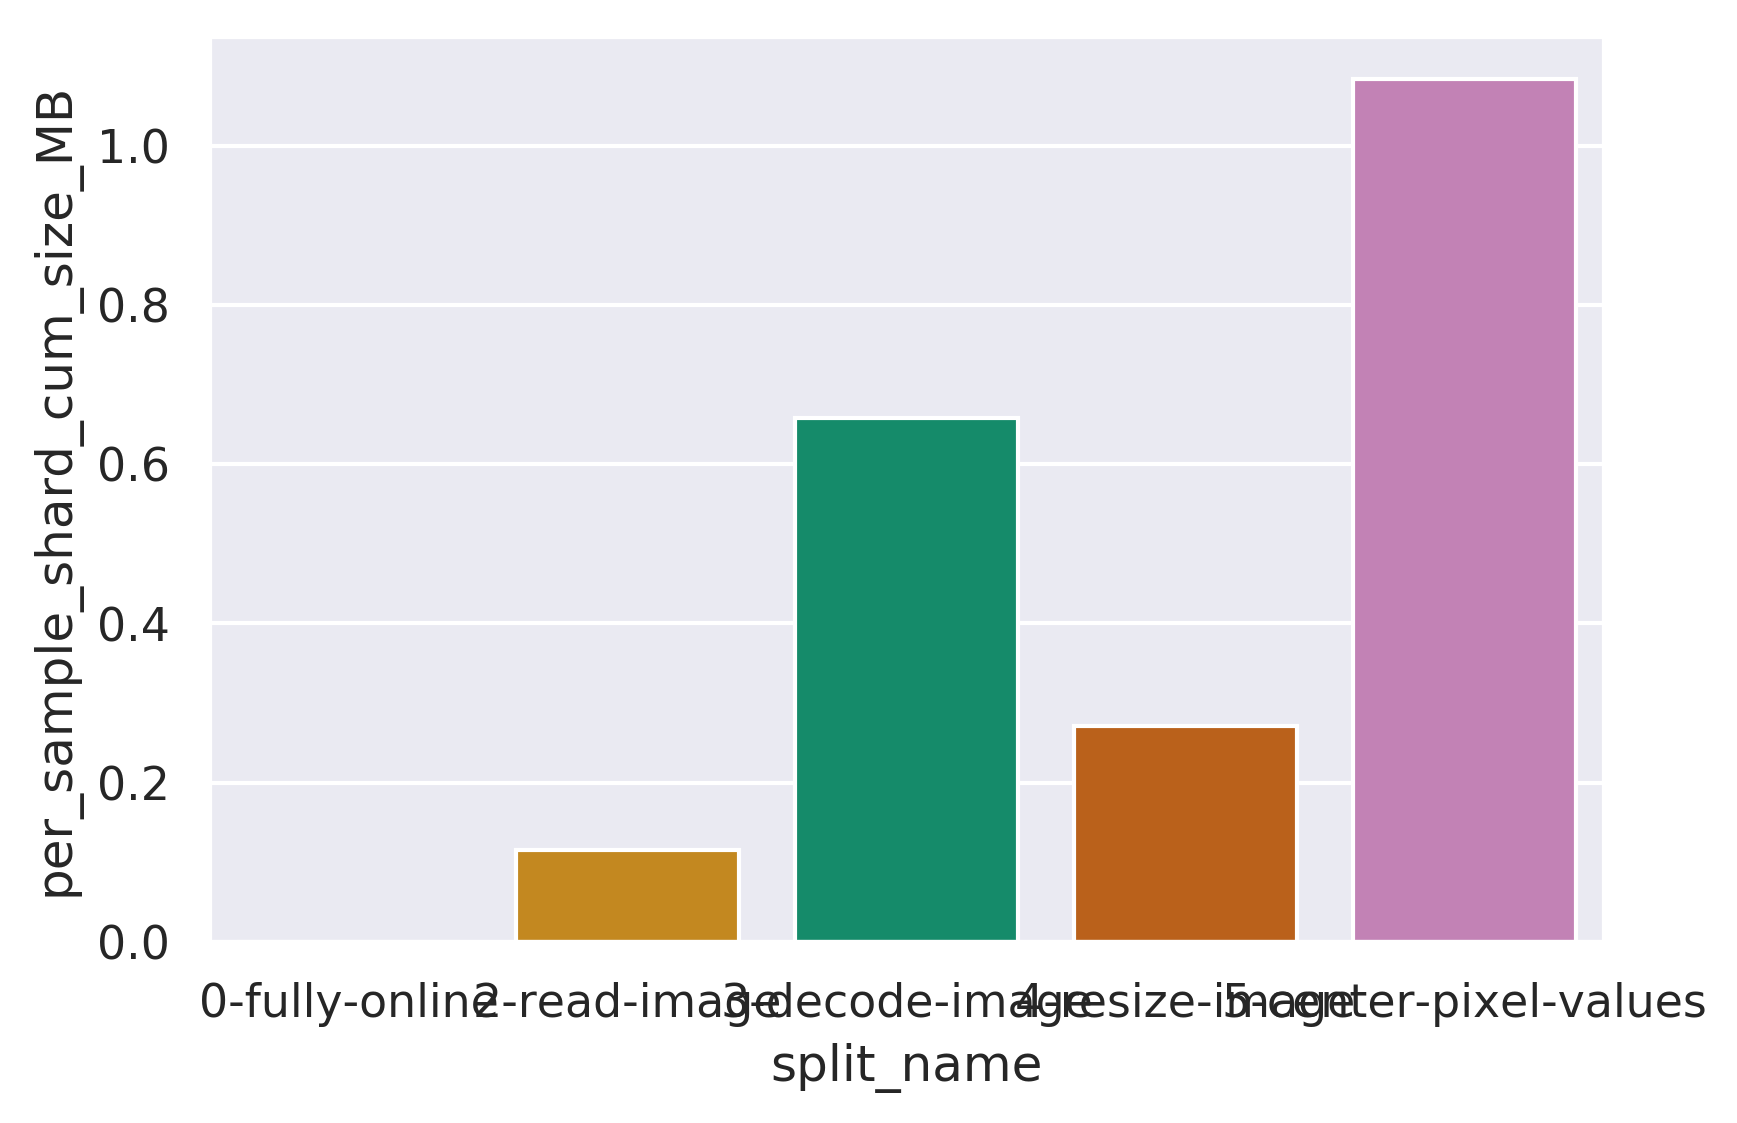

In [9]:
sns.set(palette=default_palette)
import sys

temp_df = cum_df.query(f"sample_count=={full_dataset_samplecount} and \
                                              thread_count==8 and \
                                              runs_count==0")

temp_df["per_sample_shard_cum_size_MB"] = temp_df["shard_cum_size_MB"] / full_dataset_samplecount


plot = sns.barplot(
    x="split_name",
    y="per_sample_shard_cum_size_MB",
    data=temp_df,
    ci=95
)